In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [166]:
mp4_path = r"/content/drive/MyDrive/Video_summarisation/SumMe/videos/LH44_7.mp4"

In [3]:
import os
_,file_name = os.path.split(mp4_path)
file_name = file_name[:-4]

###Taking user summary

In [4]:
import pandas as pd
import numpy as np

In [5]:
summary_dir = r'/content/drive/MyDrive/Video_summarisation/SumMe/user_frames'
summary_file = summary_dir+'/'+file_name+'.csv'

In [6]:
df_user_summary = pd.read_csv(summary_file)

In [7]:
user_summary = np.clip(df_user_summary.to_numpy(), a_min = 0, a_max = 1)

In [8]:
sum(user_summary[:,0])

666

# unsupervised leaning

1. Segment each video into shots
2. Extract features from each shot, including low-level features (such as color and motion) and high-level semantic features (such as object detection and scene recognition)
3. Cluster the shots based on their feature representations to group similar shots together
4. Identify key frames within each cluster by selecting frames that best represent the cluster
5. Order the key frames based on their importance score, which is calculated using a combination of visual and semantic information
6. Generate a summary by selecting the top-ranked key frames

## Step1

In [167]:
import cv2
def extract_shots(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    # # Group frames into shots with fixed interval of 30 frames
    # shots = []
    # start_frame = 0
    # print(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # while True:
    #     end_frame = start_frame + 29
    #     if end_frame >= cap.get(cv2.CAP_PROP_FRAME_COUNT):
    #         end_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT) - 1
    #     shots.append((int(start_frame), int(end_frame)))
    #     if end_frame >= cap.get(cv2.CAP_PROP_FRAME_COUNT) - 1:
    #         break
    #     start_frame = end_frame + 1

    # cap.release()

    return total_frames


## step 2

there are 5 features that are extracted from each frame of a shot. The first three features are color features, representing the average color of the frame in the RGB color space. The last two features are motion features, representing the magnitude and direction of the optical flow between the current and previous frame in the shot. So, you are correct that there are 3 color features and 2 motion features.

In [168]:
import cv2
import numpy as np

def compute_optical_flow(prev_gray, curr_gray, prev_pts):
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None)

    # Filter out points for which the flow is not found
    good_pts = prev_pts[status==1]
    new_pts = curr_pts[status==1]

    # Find the average flow vector
    flow_vec = np.mean(new_pts - good_pts, axis=0)

    return flow_vec

In [169]:
import cv2
import numpy as np

def extract_features(video_path, shots):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    features = []

    for shot in shots:
        start_frame, end_frame = shot
        frame_count = end_frame - start_frame + 1

        # Skip shots with less than two frames
        if frame_count < 2:
            continue

        # Initialize feature vectors
        color_features = np.zeros((frame_count, 3), dtype=np.float32)
        motion_features = np.zeros((frame_count-1, 2), dtype=np.float32)

        # Read first frame of shot
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        ret, prev_frame = cap.read()
        prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

        # Compute color feature for first frame
        color_features[0] = cv2.mean(prev_frame)[:3]

        # Initialize feature points for Lucas-Kanade method
        prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=100, qualityLevel=0.01, minDistance=10, blockSize=3)

        # Iterate over frames in shot
        for i in range(1, frame_count):
            # Read current frame
            ret, curr_frame = cap.read()
            if not ret:
                break
            curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

            # Compute color feature
            color_features[i] = cv2.mean(curr_frame)[:3]

            # Compute motion feature using Lucas-Kanade method
            flow_vec = compute_optical_flow(prev_gray, curr_gray, prev_pts)
            motion_features[i-1, 0] = np.linalg.norm(flow_vec)
            motion_features[i-1, 1] = np.arctan2(flow_vec[1], flow_vec[0])

            prev_gray = curr_gray
            prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=100, qualityLevel=0.01, minDistance=10, blockSize=3)

        # Normalize motion features
        motion_features /= np.max(motion_features, axis=0)

        # Combine color and motion features
        shot_features = np.hstack((color_features[:-1]/255, motion_features))

        # shot_features = np.mean(shot_features,axis = 0)

        # Add shot features to list of features
        features.append(shot_features)

    cap.release()

    return features


In [170]:
import cv2
import numpy as np

def extract_features(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    features = []

    # Initialize feature vectors
    color_features = np.zeros((frame_count, 3), dtype=np.float32)
    motion_features = np.zeros((frame_count-1, 2), dtype=np.float32)

    # Read first frame
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    # Compute color feature for first frame
    color_features[0] = cv2.mean(prev_frame)[:3]

    # Initialize feature points for Lucas-Kanade method
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=100, qualityLevel=0.01, minDistance=10, blockSize=3)

    # Loop over frames
    for i in range(1, frame_count):
        # Read current frame
        ret, curr_frame = cap.read()
        if not ret:
            break
        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

        # Compute color feature
        color_features[i] = cv2.mean(curr_frame)[:3]

        # Compute motion feature using Lucas-Kanade method
        flow_vec = compute_optical_flow(prev_gray, curr_gray, prev_pts)
        motion_features[i-1, 0] = np.linalg.norm(flow_vec)
        motion_features[i-1, 1] = np.arctan2(flow_vec[1], flow_vec[0])

        prev_gray = curr_gray
        prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=100, qualityLevel=0.01, minDistance=10, blockSize=3)

    # Normalize motion features
    motion_features /= np.max(motion_features, axis=0)

    # Combine color and motion features
    features = np.hstack((color_features[:-1]/255, motion_features))

    cap.release()

    return features
import cv2
import numpy as np

def extract_features(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    features = []

    # Initialize feature vectors
    color_features = np.zeros((frame_count, 3), dtype=np.float32)
    motion_features = np.zeros((frame_count-1, 2), dtype=np.float32)

    # Read first frame
    ret, prev_frame = cap.read()
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    # Compute color feature for first frame
    color_features[0] = cv2.mean(prev_frame)[:3]

    # Initialize feature points for Lucas-Kanade method
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=100, qualityLevel=0.01, minDistance=10, blockSize=3)

    # Loop over frames
    for i in range(1, frame_count):
        # Read current frame
        ret, curr_frame = cap.read()
        if not ret:
            break
        curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

        # Compute color feature
        color_features[i] = cv2.mean(curr_frame)[:3]

        # Compute motion feature using Lucas-Kanade method
        flow_vec = compute_optical_flow(prev_gray, curr_gray, prev_pts)
        motion_features[i-1, 0] = np.linalg.norm(flow_vec)
        motion_features[i-1, 1] = np.arctan2(flow_vec[1], flow_vec[0])

        prev_gray = curr_gray
        prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=100, qualityLevel=0.01, minDistance=10, blockSize=3)

    # Normalize motion features
    motion_features /= np.max(motion_features, axis=0)

    # Combine color and motion features
    features = np.hstack((color_features[:-1]/255, motion_features))

    cap.release()

    return features


## step 3

In [171]:
from sklearn.cluster import KMeans
import numpy as np

def cluster_shots(features, num_clusters):
    stacked_features = features
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(stacked_features)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    cluster_sizes = np.bincount(labels)
    cluster_indices = np.split(np.argsort(labels), np.cumsum(cluster_sizes)[:-1])

    clusters = [list(ci) for ci in cluster_indices]
    
    return clusters, centroids, kmeans


### other methods (dont use)

In [172]:
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA

# def cluster_shots(features, num_clusters):
#     # Reduce the dimensionality of the feature vectors using PCA
#     stacked_features = np.vstack(features)
#     pca = PCA(n_components=2)
#     features_pca = pca.fit_transform(stacked_features)

#     # Perform clustering on the reduced feature vectors
#     kmeans = KMeans(n_clusters=num_clusters)
#     kmeans.fit(features_pca)
#     labels = kmeans.labels_
#     centroids = kmeans.cluster_centers_

#     # Create list of clusters based on labels
#     clusters = [[] for _ in range(num_clusters)]
#     [clusters[label].append(i) for i, label in enumerate(labels)]
    
#     return clusters, centroids


In [173]:
# from sklearn.cluster import AgglomerativeClustering
# import numpy as np

# def cluster_shots(features, num_clusters):
#     stacked_features = np.vstack(features)
#     agg = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
#     labels = agg.fit_predict(stacked_features)
    
#     clusters = [[] for _ in range(num_clusters)]
#     cluster_sizes = np.bincount(labels, minlength=num_clusters)  # initialize cluster_sizes to have length num_clusters
#     cluster_sizes_cumsum = np.cumsum(cluster_sizes)
#     shot_indices = np.arange(len(features))
    
#     label_indices = np.argsort(labels)
#     current_cluster = 0
#     for i in range(len(label_indices)):
#         while i >= cluster_sizes_cumsum[current_cluster]:
#             current_cluster += 1
#         if current_cluster >= num_clusters:  # check if current_cluster is out of bounds
#             break
#         shot_index = shot_indices[label_indices[i]]
#         clusters[current_cluster].append(shot_index)
    
#     centroids = []
#     for i in range(num_clusters):
#         centroid = np.mean([features[j] for j in clusters[i]], axis=0)
#         centroids.append(centroid)

#     return clusters, centroids


In [174]:
# from sklearn.cluster import AgglomerativeClustering
# import numpy as np

# def cluster_shots(features, num_clusters):
#     # Reduce the dimensionality of the feature vectors using PCA
#     stacked_features = np.vstack(features)
#     pca = PCA(n_components=5)
#     features_pca = pca.fit_transform(stacked_features)
#     agg = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
#     labels = agg.fit_predict(features_pca)
    
#     clusters = [[] for _ in range(num_clusters)]
#     cluster_sizes = np.bincount(labels)
#     cluster_sizes_cumsum = np.cumsum(cluster_sizes)
#     shot_indices = np.arange(len(features))
    
#     label_indices = np.argsort(labels)
#     current_cluster = 0
#     for i in range(len(label_indices)):
#         while i >= cluster_sizes_cumsum[current_cluster]:
#             current_cluster += 1
#         shot_index = shot_indices[label_indices[i]]
#         clusters[current_cluster].append(shot_index)

#     return clusters

## step 4

### for full length video

In [178]:
# def identify_keyframes(clusters, features):
#     keyframes = []
#     stacked_features = features

#     for cluster in clusters:
#         # Find representative shot for cluster (shot with smallest Euclidean distance to cluster centroid)
#         cluster_features = np.array([stacked_features[i] for i in cluster])
#         centroid = np.mean(cluster_features, axis=0)
#         distances = np.linalg.norm(cluster_features - centroid, axis=1)
#         representative_shot = cluster[np.argmin(distances)]

#         # Add keyframe for representative shot (first frame of representative shot)
#         keyframes.append(representative_shot)

#     return keyframes


### for initial nsec of the video

In [179]:
def pick_centroids(clusters, features):
    centroids = []

    stacked_features = features

    for i, cluster in enumerate(clusters):
        # Find cluster centroid
        cluster_features = np.array([stacked_features[i] for i in cluster])
        centroid = np.mean(cluster_features, axis=0)

        # Check if centroid meets criteria (average color and high motion magnitude)
        color_features = centroid[:3]
        motion_features = centroid[3:]
        motion_mag = np.linalg.norm(motion_features)
        c = 0.49
        m = 0.7
        if color_features[0] > c and color_features[1] > c and color_features[2] > c and motion_mag > m:
            centroids.append((i,centroid))

    centroids = np.array(centroids)
    sorted_centroids = sorted(centroids, key=lambda x: np.mean(x[1][:4]), reverse=True)
    
    return sorted_centroids


In [180]:
def pick_keyframes_from_centroids(centroids, clusters, features):
    keyframes = []
    stacked_features = features

    for i in range(len(centroids)):
        centroid_index = centroids[i][0]  # get the centroid index from the sorted centroids array
        cluster = clusters[centroid_index]
        centroid = centroids[i][1]

        # Find distances from each shot to centroid
        distances = np.linalg.norm(stacked_features[cluster] - centroid, axis=1)
        distances.sort()

        # Select closest shots to centroid
        closest_shots = [cluster[j] for j in np.argsort(distances)[:1]]

        keyframes.append(closest_shots)
    return keyframes

In [181]:
def create_keyshots(d,nframes,keyframes):
    keyframe_list = []
    for i in keyframes:
        l = i - d
        u = i + d
        r = np.arange(l,u)
        keyframe_list.append(r)
    keyshots = np.unique(np.clip(np.hstack(keyframe_list), a_min = 0, a_max = nframes-2))

    return keyshots

## step 5

In [182]:
def calculate_importance_score(keyframes, features):
    stacked_features = features
    # Compute visual scores (based on color and motion features)
    color_features = np.array([stacked_features[i][:3] for i in keyframes])
    motion_features = np.array([stacked_features[i][3:] for i in keyframes])
    color_scores = np.linalg.norm(color_features, axis=1)
    motion_scores = np.linalg.norm(motion_features, axis=1)
    visual_scores = color_scores + motion_scores

    # # Compute semantic scores (based on cluster labels and semantic scores)
    # cluster_sizes = [len(cluster) for cluster in labels]
    # cluster_weights = np.array(cluster_sizes) / np.sum(cluster_sizes)
    # semantic_scores = np.array([semantic_scores[i] for i in labels])
    # semantic_scores_weighted = np.sum(semantic_scores * cluster_weights, axis=1)
    # semantic_scores_normalized = (semantic_scores_weighted - np.min(semantic_scores_weighted)) / (np.max(semantic_scores_weighted) - np.min(semantic_scores_weighted))
    # semantic_scores_normalized = np.clip(semantic_scores_normalized, 0, 1)

    # Combine visual and semantic scores to get importance scores
    # importance_scores = 0.5 * visual_scores + 0.5 * semantic_scores_normalized

    importance_scores = np.round(visual_scores,3)

    # # Sort keyframes by importance score
    # sorted_indices = np.argsort(importance_scores)[::-1]
    # sorted_keyframes = [keyframes[i] for i in sorted_indices]

    return importance_scores

## step 6

In [183]:
def generate_summary(keyframes):
    # Sort keyframes by index (to ensure temporal order)
    keyframes = sorted(keyframes)

    # Select top-ranked keyframes based on their index
    summary = keyframes

    return summary

## implementation

In [184]:
import cv2
import numpy as np

 # Step 1: Segment the video into shots
video_file = mp4_path
nframes = extract_shots(video_file)
print('step_1_done')

step_1_done


In [185]:
# Step 2: Extract features from each shot (color and motion)
features = extract_features(video_file)
print('step_2_done')

step_2_done


In [186]:
# Step 3: Cluster shots based on their feature representations
num_clusters = int(.15*len(features))
# num_clusters = 75
clusters, centroids, kmeans = cluster_shots(features, num_clusters)
print('step_3_done')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


step_3_done


In [89]:
# # Step 4: Identify keyframes within each cluster for full length
# keyframes = identify_keyframes(clusters, features)
# print('step_4_done')

In [187]:
# # Step 4: Identify keyframes within each cluster for first nsec
sorted_centroids = pick_centroids(clusters, features)
keyframes_list = pick_keyframes_from_centroids(sorted_centroids, clusters, features)
keyframes = np.concatenate(keyframes_list)

d = int(0.15*nframes/len(keyframes))
# d = 5
keyshots = create_keyshots(d,nframes,keyframes)
keyframes = keyshots.astype(int)
print('step_4_done')

step_4_done


<ipython-input-179-ee02fbade868>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centroids = np.array(centroids)


In [188]:
# Step 5: Calculate importance scores
importance_scores = calculate_importance_score(keyframes, features)
print('step_5_done')

step_5_done


In [189]:
# Step 6: Generate summary by selecting top-ranked keyframes
summary = generate_summary(keyframes)
summary_unsup = summary
print('step_6_done')

step_6_done


# plotting

In [152]:
stacked_features = features

In [153]:
summary_array = np.zeros(len(stacked_features))
summary_array[summary] = 1
summary_array_unsup = summary_array

In [154]:
sum(summary_array)

721.0

# Step 7 (comapring to user summary)

In [155]:
np.arange(np.shape(user_summary)[1])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [156]:
from sklearn.metrics import classification_report

jaccard_similarity = []
f1_scores = []
for i in np.arange(np.shape(user_summary)[1]):
    intersection = np.logical_and(user_summary[:,i].astype(bool), summary_array.astype(bool))
    union = np.logical_or(user_summary[:,i].astype(bool), summary_array.astype(bool))
    jaccard_similarity.append(np.sum(intersection) / np.sum(union)*100)
    f1_scores.append(classification_report(user_summary[:,1], summary_array))
print(jaccard_similarity)

[11.584875301689461, 11.03896103896104, 0.0, 28.251121076233183, 4.450041981528128, 17.6759410801964, 10.358255451713395, 24.78031634446397, 8.112206216830932, 0.9717314487632509, 36.04985618408437, 28.98148148148148, 14.571657325860688, 2.049780380673499, 21.610169491525426, 14.262948207171315, 26.63716814159292, 9.077040427154843]


<ipython-input-157-a459cc76e2a9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['','Not selected','','','','selected'])
<ipython-input-157-a459cc76e2a9>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['','Not selected','','','','selected'])


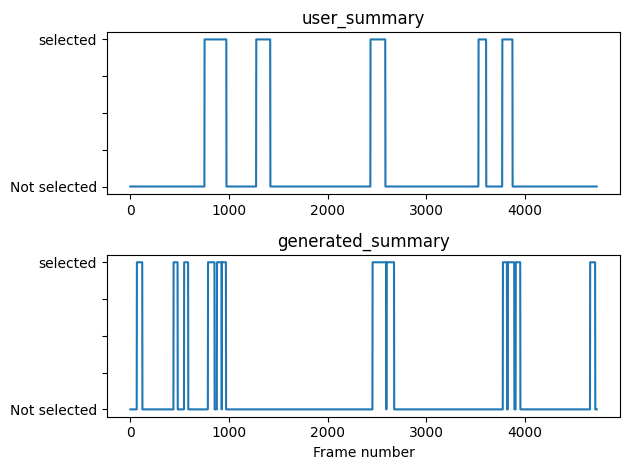

In [157]:
import matplotlib.pyplot as plt
fig, [ax1,ax2] = plt.subplots(2,1)
ax1.plot(user_summary[:,10])
ax2.plot(summary_array)
ax1.title.set_text('user_summary')
ax2.title.set_text('generated_summary')
ax1.set_yticklabels(['','Not selected','','','','selected'])
ax2.set_yticklabels(['','Not selected','','','','selected'])
ax2.set_xlabel('Frame number')
fig.tight_layout()

Text(0, 0.5, 'jaccard_similarity_%')

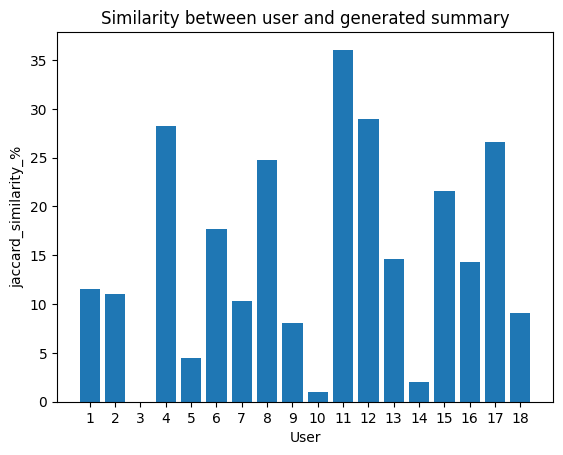

In [158]:
fig, ax = plt.subplots()
ax.bar(np.arange(np.shape(user_summary)[1]),jaccard_similarity)
ax.set_xticks(np.arange(0,np.shape(user_summary)[1]),np.arange(1,np.shape(user_summary)[1]+1))
ax.title.set_text('Similarity between user and generated summary')
ax.set_xlabel('User')
ax.set_ylabel('jaccard_similarity_%')

# creating summary array for supervised learning

In [37]:
s_stacked_features = stacked_features
for i in range(np.shape(user_summary)[1]-1):
    s_stacked_features = np.concatenate((s_stacked_features, stacked_features))

In [38]:
user_summary_array = user_summary.flatten(order='F')

In [39]:
max(user_summary_array)

1

# supervised learning

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Load dataset
# X = np.load('features.npy')  # shape (n_frames, n_features)
# y = np.load('summary.npy')  # shape (n_frames,)
X = s_stacked_features
y = user_summary_array

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
# clf = LogisticRegression()
# clf = RandomForestClassifier(n_estimators=100, random_state=5)
# clf = SVC(kernel='rbf', random_state=42)
# clf = KNeighborsClassifier(n_neighbors=5)
clf = GaussianNB()

clf.fit(X_train, y_train)

# Evaluate the model on the testing set
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")


Accuracy: 0.86


### CNN and RNN (LSTM)

In [56]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D

# Load dataset
# X = np.load('features.npy')  # shape (n_frames, n_features)
# y = np.load('summary.npy')  # shape (n_frames,)
X = s_stacked_features
y = user_summary_array

# Reshape input data for LSTM
n_timesteps, n_features = 1, X.shape[1]
X = X.reshape((X.shape[0], n_timesteps, n_features))

# Define LSTM model with multiple layers
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(MaxPooling1D(pool_size=1))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='RMSProp', metrics=['accuracy'])

# Train the model with additional regularization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min', min_lr=0.0001)

model.fit(X, y, epochs=20, batch_size=64, validation_split=0.2)#, callbacks=[early_stop, reduce_lr])

Epoch 1/20
1064/1064 [==============================] - 14s 7ms/step - loss: 0.4143 - accuracy: 0.8631 - val_loss: 0.4180 - val_accuracy: 0.8527
Epoch 2/20
1064/1064 [==============================] - 7s 6ms/step - loss: 0.4014 - accuracy: 0.8633 - val_loss: 0.4175 - val_accuracy: 0.8527
Epoch 3/20
1064/1064 [==============================] - 6s 6ms/step - loss: 0.4001 - accuracy: 0.8633 - val_loss: 0.4171 - val_accuracy: 0.8527
Epoch 4/20
1064/1064 [==============================] - 7s 6ms/step - loss: 0.3986 - accuracy: 0.8633 - val_loss: 0.4159 - val_accuracy: 0.8527
Epoch 5/20
1064/1064 [==============================] - 7s 6ms/step - loss: 0.3987 - accuracy: 0.8633 - val_loss: 0.4154 - val_accuracy: 0.8527
Epoch 6/20
1064/1064 [==============================] - 6s 5ms/step - loss: 0.3977 - accuracy: 0.8633 - val_loss: 0.4140 - val_accuracy: 0.8527
Epoch 7/20
1064/1064 [==============================] - 7s 7ms/step - loss: 0.3969 - accuracy: 0.8633 - val_loss: 0.4143 - val_accuracy

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm (LSTM)                 (None, 1, 32)             12416     
                                                                 
 dropout_1 (Dropout)         (None, 1, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                        

### DNN

In [ ]:
# import numpy as np
# from keras.models import Sequential
# from keras.layers import Dense, Dropout

# # Load dataset
# # X = np.load('features.npy')  # shape (n_frames, n_features)
# # y = np.load('summary.npy')  # shape (n_frames,)
# X = s_stacked_features
# y = user_summary_array

# # Define DNN model with multiple layers
# model = Sequential()
# model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model with additional regularization
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min', min_lr=0.0001)

# model.fit(X, y, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stop, reduce_lr])


### RNN

In [ ]:
# import numpy as np
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout

# # Load dataset
# # X = np.load('features.npy')  # shape (n_frames, n_features)
# # y = np.load('summary.npy')  # shape (n_frames,)
# X = s_stacked_features
# y = user_summary_array

# # Reshape input data for LSTM
# n_timesteps, n_features = 1, X.shape[1]
# X = X.reshape((X.shape[0], n_timesteps, n_features))

# # Define LSTM model with multiple layers
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, input_shape=(n_timesteps, n_features)))
# model.add(Dropout(0.2))
# model.add(LSTM(32, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(16))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

# # Train the model with additional regularization
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min', min_lr=0.0001)

# model.fit(X, y, epochs=20, batch_size=64, validation_split=0.3, callbacks=[early_stop, reduce_lr])


### CM

In [111]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [58]:
jaccard_similarity = []
for i in np.arange(np.shape(user_summary)[1]):
    intersection = np.logical_and(user_summary[:,i].astype(bool), summary_array.astype(bool))
    union = np.logical_or(user_summary[:,i].astype(bool), summary_array.astype(bool))
    jaccard_similarity.append(np.sum(intersection) / np.sum(union)*100)
print(jaccard_similarity)

[11.745334796926453, 0.7056451612903225, 3.825857519788918, 6.847935548841893, 9.238451935081148, 8.308004052684904, 14.660831509846828, 5.416248746238716, 3.525954946131244, 0.38910505836575876, 12.781954887218044, 9.052183173588926, 15.184381778741866, 9.275053304904052, 5.33596837944664, 7.250755287009064, 11.554621848739496, 10.751565762004175]


In [59]:
# Load dataset
X = features
y = user_summary[:,0]

# Reshape input data for LSTM
n_timesteps, n_features = 1, X.shape[1]
X = X.reshape((X.shape[0], n_timesteps, n_features))

# Predict the summary array
y_pred = model.predict(X)
y_pred_binary = (y_pred > 0.23).astype(int) #0.225, 0.23


# Generate confusion matrix
cm = confusion_matrix(y, y_pred_binary)

# Generate classification report
target_names = ['0', '1']
print(classification_report(y, y_pred_binary, target_names=target_names))

148/148 [==============================] - 1s 2ms/step


In [191]:
# # Load dataset
# X = features


# # Reshape input data for LSTM
# n_timesteps, n_features = 1, X.shape[1]
# X = X.reshape((X.shape[0], n_timesteps, n_features))

# # Predict the summary array
# y_pred = model.predict(X)
# y_pred_binary = (y_pred > 0.23).astype(int) #0.225, 0.23

98/98 [==============================] - 0s 2ms/step


In [112]:
target_names = ['0', '1']
print(classification_report(y, y_pred_binary, target_names=target_names))

              precision    recall  f1-score   support

           0       0.86      0.97      0.92      4062
           1       0.30      0.07      0.12       666

    accuracy                           0.85      4728
   macro avg       0.58      0.52      0.52      4728
weighted avg       0.79      0.85      0.80      4728



In [110]:
cm

array([[3949,  113],
       [ 617,   49]])

In [159]:
sum(y_pred_binary)

array([162])

In [160]:
indices,_ = np.where(y_pred_binary == 1)

In [161]:
len(features)

4728

In [192]:
d = int(0.15*nframes/len(indices))
keyshots = create_keyshots(d,nframes,indices)
keyframes = keyshots.astype(int)
summary = keyframes
summary_sup = summary

In [193]:
keyshots = np.zeros(len(features))
keyshots[keyframes] = 1
summary_array = keyshots
summary_array_sup = keyshots

In [105]:
jaccard_similarity = []
for i in np.arange(np.shape(user_summary)[1]):
    intersection = np.logical_and(user_summary[:,i].astype(bool), keyshots.astype(bool))
    union = np.logical_or(user_summary[:,i].astype(bool), keyshots.astype(bool))
    jaccard_similarity.append(np.sum(intersection) / np.sum(union)*100)
print(jaccard_similarity)

[14.00862068965517, 2.1632251720747298, 9.827357237715804, 4.757373929590866, 18.36998706338939, 8.93909626719057, 17.115177610333692, 7.699901283316881, 7.549019607843137, 1.2437810945273633, 14.616193480546794, 11.064718162839249, 21.499448732083792, 16.52078774617068, 3.2679738562091507, 12.755102040816327, 16.985138004246284, 16.878980891719745]


<ipython-input-106-ec61db583263>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['','Not selected','','','','selected'])
<ipython-input-106-ec61db583263>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['','Not selected','','','','selected'])


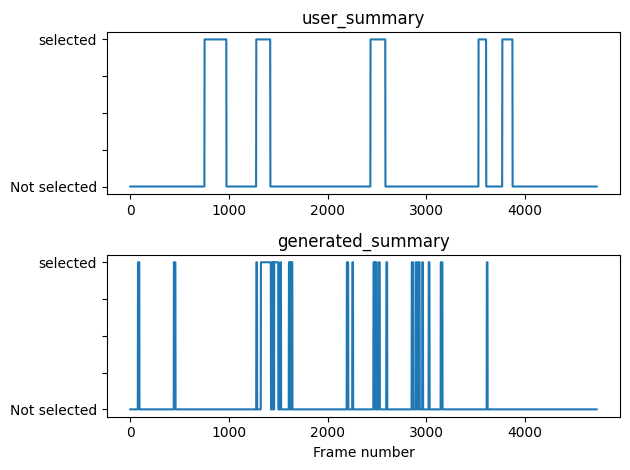

In [106]:
import matplotlib.pyplot as plt
# plt.plot(user_summary[:,10])
# plt.plot(keyshots)
fig, [ax1,ax2] = plt.subplots(2,1)
ax1.plot(user_summary[:,10])
ax2.plot(summary_array)
ax1.title.set_text('user_summary')
ax2.title.set_text('generated_summary')
ax1.set_yticklabels(['','Not selected','','','','selected'])
ax2.set_yticklabels(['','Not selected','','','','selected'])
ax2.set_xlabel('Frame number')
fig.tight_layout()

Text(0, 0.5, 'jaccard_similarity_%')

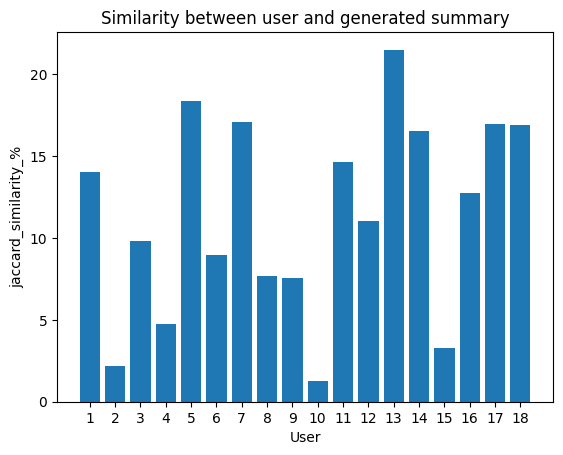

In [107]:
fig, ax = plt.subplots()
ax.bar(np.arange(np.shape(user_summary)[1]),jaccard_similarity)
ax.set_xticks(np.arange(0,np.shape(user_summary)[1]),np.arange(1,np.shape(user_summary)[1]+1))
ax.title.set_text('Similarity between user and generated summary')
ax.set_xlabel('User')
ax.set_ylabel('jaccard_similarity_%')

<ipython-input-109-ec2eab701abf>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['','Not selected','','','','selected'])
<ipython-input-109-ec2eab701abf>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['','Not selected','','','','selected'])


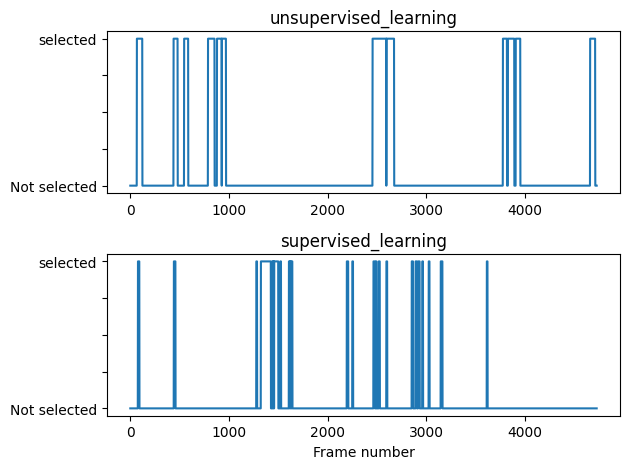

In [109]:
import matplotlib.pyplot as plt
# plt.plot(user_summary[:,10])
# plt.plot(keyshots)
fig, [ax1,ax2] = plt.subplots(2,1)
ax1.plot(summary_array_unsup)
ax2.plot(summary_array_sup)
ax1.title.set_text('unsupervised_learning')
ax2.title.set_text('supervised_learning')
ax1.set_yticklabels(['','Not selected','','','','selected'])
ax2.set_yticklabels(['','Not selected','','','','selected'])
ax2.set_xlabel('Frame number')
fig.tight_layout()

In [68]:
df_ypred = pd.DataFrame(y_pred, columns=["y_pred"])
df_ypred.describe()

,y_pred
count,4728.000000
mean,0.143651
std,0.052062
min,0.011638
25%,0.107435
50%,0.148658
75%,0.181990
max,0.267305


In [69]:
# import cv2
# import imageio

# # Load video using OpenCV
# cap = cv2.VideoCapture(video_file)

# # Extract frames corresponding to summary frames and save as a new GIF
# out_file = 'summary.gif'
# writer = imageio.get_writer(out_file, mode='I', duration=0.1)

# for frame_idx in summary:
#     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
#     ret, frame = cap.read()
#     if ret:
#         writer.append_data(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# cap.release()
# writer.close()

# print('gif created')

#exporting the gif

In [194]:
import imageio
import os
from skimage.transform import resize

# Load video using imageio
reader = imageio.get_reader(video_file)

# Extract frames corresponding to summary frames and save as a new GIF
out_file = '/content/drive/MyDrive/Video_summarisation/summary_supervised_random.gif'
fps = reader.get_meta_data()['fps']
writer = imageio.get_writer(out_file, fps=fps)

for frame_idx in summary_sup:
    frame = reader.get_data(frame_idx)
    frame_resized = resize(frame, (480, 854))
    writer.append_data(frame)

writer.close()

print('gif_created')

gif_created
